In [121]:
'''eval a bunch of models for tz
'''
import numpy as np
import os
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns

from data import get_data_tz, run_exp_tz
from models import LCALSTM
from models import pick_action
from analysis import compute_predacc, compute_dks
from utils.utils import to_np, to_sqnp
from utils.params import P
from utils.io import build_log_path, load_ckpt
from scipy.stats import sem
from plt_helper import plot_pred_acc_full, compute_summary_stats

sns.set(style='white', context='talk', palette='colorblind')
alpha = .3
n_se = 2
dpi = 100

In [110]:
'''input args'''
# log_root = '../log/'
log_root = '/tigress/qlu/logs/learn-hippocampus/log/'
exp_name = 'rmob'
epoch_load = 300
penalty = 8
subj_id = 4

n_param = 11
n_branch = 3
n_hidden = 128
learning_rate = 1e-3
p_rm_ob_enc = .1

'''fixed params'''
# log params
p = P(
    exp_name=exp_name,
    n_param=n_param, penalty=penalty, n_hidden=n_hidden, lr=learning_rate,
    p_rm_ob_enc=p_rm_ob_enc  
)
agent = LCALSTM(
    p.net.state_dim, p.net.n_hidden, p.net.n_action,
    recall_func=p.net.recall_func, kernel=p.net.kernel,
)
optimizer = optim.Adam(agent.parameters(), lr=p.net.lr)


# create logging dirs
log_path, log_subpath = build_log_path(subj_id, p, log_root=log_root)
agent, _ = load_ckpt(epoch_load, log_subpath['ckpts'], agent, optimizer)

Use exisiting dir: 
/tigress/qlu/logs/learn-hippocampus/log/exp-rmob/p-11_b-3/pad-1/tp-0.33/p_rm_ob_rcl-0.00_enc-0.10/lp-8/enc-cum_size-12/rp-LCA_metric-cosine/h-128/lr-0.001/subj-4
- use exisiting sub dir: ckpts
- use exisiting sub dir: data
- use exisiting sub dir: figs
- use exisiting sub dir: rnr-data
- use exisiting sub dir: rnr-ckpts
- use exisiting sub dir: rnr-figs
epoch 300 loaded


In [116]:
def compute_corrects_and_dks(Y, log_adist, p): 
    # compuet corrects and dk indicator mats
    Y_np = np.squeeze(to_np(Y))
    corrects = compute_predacc(Y_np, log_adist)
    dks = compute_dks(log_adist)
    # trim event end points
    corrects_ = np.delete(corrects, p.env.tz.event_ends, axis=1)
    dks_ = np.delete(dks, p.env.tz.event_ends, axis=1)
    return corrects_, dks_

# make test set
tz_cond = 'RM'
n_examples_test = 300

# control condition
p.env.p_rm_ob_enc = 0
[X, Y], _ = get_data_tz(n_examples_test, p)
perfm_metrics, cache_return = run_exp_tz(
    agent, optimizer, X, Y, p,
    cond=tz_cond, supervised=False,
    learning=False,
)
log_loss_i, log_return_i, log_adist_i = perfm_metrics
[Y, log_adist, C, H, M, V, Vector, Scalar, misc_return] = cache_return
corrects_b, dks_b = compute_corrects_and_dks(Y, log_adist, p)

# test condition
p.env.p_rm_ob_enc = .1
[X, Y], metadata = get_data_tz(n_examples_test, p)
perfm_metrics, cache_return = run_exp_tz(
    agent, optimizer, X, Y, p,
    cond=tz_cond, supervised=False,
    learning=False,
)
log_loss_i, log_return_i, log_adist_i = perfm_metrics
[Y, log_adist, C, H, M, V, Vector, Scalar, misc_return] = cache_return
corrects_, dks_ = compute_corrects_and_dks(Y, log_adist, p)
# get parameter withheld
param_withheld_all = metadata[1]
param_withheld = np.squeeze(param_withheld_all)[:,0]

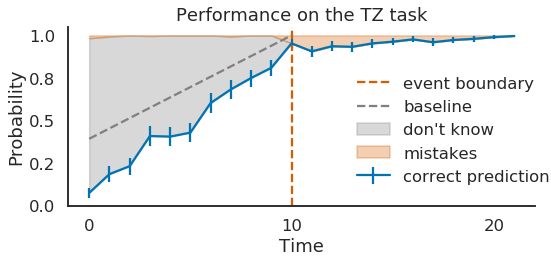

In [118]:
# compute mus
pa_mu, pa_er = compute_summary_stats(corrects_)
dk_probs_mu, dk_probs_er = compute_summary_stats(dks_)
pa_or_dk_mu = pa_mu + dk_probs_mu

# plot individual results
event_bounds = p.env.tz.event_ends[:-1]
f, ax = plt.subplots(1, 1, figsize=(8, 4), sharex=True)
plot_pred_acc_full(
    pa_mu, pa_er, pa_or_dk_mu, event_bounds, p,
    f, ax
)

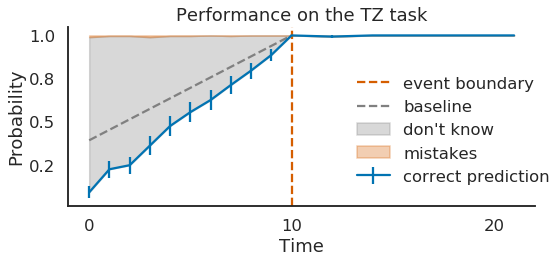

In [119]:
pa_mu_b, pa_er_b = compute_summary_stats(corrects_b)
dk_probs_mu_b, dk_probs_er_b = compute_summary_stats(dks_b)
pa_or_dk_mu_b = pa_mu_b + dk_probs_mu_b

# plot individual results
event_bounds = p.env.tz.event_ends[:-1]
f, ax = plt.subplots(1, 1, figsize=(8, 4), sharex=True)
plot_pred_acc_full(
    pa_mu_b, pa_er_b, pa_or_dk_mu_b, event_bounds, p,
    f, ax
)

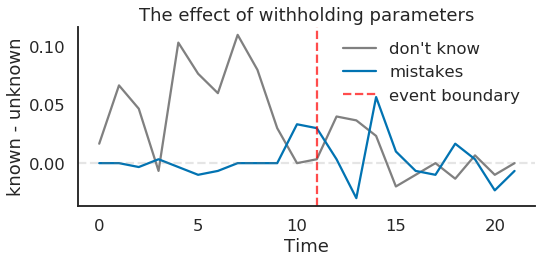

In [115]:
f, ax = plt.subplots(1,1, figsize=(8, 4))

dk_diff = dk_probs_mu - dk_probs_mu_b
mistake_diff = (1 - pa_or_dk_mu) - (1 - pa_or_dk_mu_b)


ax.plot(dk_diff, color = 'grey', label='don\'t know')
ax.plot(mistake_diff, label='mistakes')
ax.axvline(event_bounds, color='red',  linestyle='--', label='event boundary', alpha = .7)
ax.legend(frameon=False)

ax.axhline(0, color='grey',  linestyle='--', alpha = .2)

ax.set_ylabel('known - unknown')
ax.set_xlabel('Time')
ax.set_title('The effect of withholding parameters')

sns.despine()
f.tight_layout()

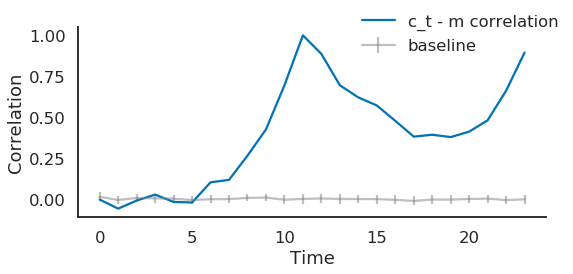

In [189]:
def _compute_cm_corr_baseline(C_i, p, scale):
    T = p.env.tz.total_len
    x = np.random.normal(size=(p.net.n_hidden,), scale=scale)
    r_baseline = np.squeeze([np.corrcoef(x, C_i[t])[0,1] for t in range(T)])
    return r_baseline

def compute_cm_corr_baseline(C_i, p, scale=1, n_samples = 100, n_se=3):
    r_baseline = np.zeros((n_samples, p.env.tz.total_len))
    for i in range(n_samples):
        r_baseline[i, :] = _compute_cm_corr_baseline(C_i, p, scale=scale)
    r_baseline_mu = np.mean(r_baseline,axis=0)
    r_baseline_er = sem(r_baseline,axis=0) * n_se
    return r_baseline_mu, r_baseline_er

t_memory = 11
T_total = p.env.tz.total_len
r_baseline_mu, r_baseline_er = compute_cm_corr_baseline(C_i, p)
cm_corr = np.squeeze([np.corrcoef(C_i[t_memory], C_i[t])[0,1] for t in range(T_total)])

f, ax = plt.subplots(1,1, figsize=(8, 4))

ax.plot(cm_corr, label = 'c_t - m correlation')
ax.errorbar(
    x=range(T_total),
    y=r_baseline_mu, yerr=r_baseline_er, 
    color='grey', alpha = .5, label = 'baseline'
)
ax.set_xlabel('Time')
ax.set_ylabel('Correlation')
f.legend(frameon=False)
sns.despine()
f.tight_layout()